In [2]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import rcParams
from termcolor import colored
import scipy.stats as stats
import seaborn as sns
import numpy as np  
from prettytable import PrettyTable
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb


In [3]:
rcParams['figure.figsize'] = 12, 5

In [4]:
yf.download("BZ=F", start="2005-01-01")

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513
2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930
2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180
2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387
...,...,...,...,...,...,...
2025-02-03,76.820000,77.529999,75.040001,75.959999,75.959999,75087
2025-02-04,75.519997,76.669998,74.129997,76.199997,76.199997,62716
2025-02-05,76.080002,76.349998,74.550003,74.610001,74.610001,30739


In [5]:
class ForecastPetroleo():
    def __init__(self, ticker="BZ=F"):
        self.ticker = ticker
        self.data = yf.download(ticker)
        self.df = self.create_features(self.data)



    def fit(self):
        return self
    
    def create_features(self, df):
        data_frame = df.copy()
        data_frame["data"] = pd.to_datetime(df.index)
        data_frame['ano'] = data_frame['data'].dt.year
        data_frame['mes'] = data_frame['data'].dt.month
        data_frame['dia'] = data_frame['data'].dt.day
        data_frame.rename(columns={'Close': 'valor_fechamento'}, inplace=True)
        data_frame.rename(columns={'Open': 'valor_abertura'}, inplace=True)        
        data_frame['dia_da_semana'] = data_frame['data'].dt.dayofweek
        
        return data_frame

    def plotarSerie(self, serie, titulo="Valores do petroleo com base no fechamento diário", legendas=[]):        
        serie.plot()    
        plt.title(titulo)
        plt.xlabel('Data')
        plt.grid(visible=True, linestyle='-', linewidth=0.7)
        plt.ylabel('Valor em Dolar')
        if legendas:
            plt.legend(labels=legendas, loc='best')
    
    def plotar_medias_moveis(self, serie, titulo ='Valor Fechamento Petroleo com média móvel' ):
        dias_uteis = 22
        serie_media_movel_30 = serie.rolling(dias_uteis).mean()
        serie_media_movel_90 = serie.rolling(dias_uteis * 3).mean()
        serie_media_movel_anual = serie.rolling(dias_uteis * 12).mean()
        self.plotarSerie(serie)
        self.plotarSerie(serie_media_movel_30)
        self.plotarSerie(serie_media_movel_90)
        self.plotarSerie(serie_media_movel_anual, titulo ,['Valor Real','Média Móvel Mensal', 'Média Móvel Trimestral', 'Média Móvel Anual'])
        plt.show()
    
    def calculate_metrics(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = root_mean_squared_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        return mae, mse, mape


    def print_metrics(self, metrics):
        mae, mse, mape = metrics
        print(colored(f"MAE: {mae}", 'light_blue'))
        print(colored(f"MSE: {mse}", 'light_cyan'))
        print(colored(f"MAPE: {mape:.2f} %", 'light_green'))

    def reverter_diferenciacao(serie,serie_diferenciada):

        ultimo_valor = serie.iloc[-1]
        serie_normalizada = ultimo_valor + serie_diferenciada.cumsum()
        serie_normalizada

        return serie_normalizada    

    def prepare_data(self):
        df_feature = self.df.copy()
        df_feature.sort_values(by = 'data', inplace=True)
        feature_names = ["ano", "mes", "dia", "dia_da_semana","valor_abertura"]
        target = "valor_fechamento"

        X = df_feature[feature_names]
        y = df_feature[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  shuffle=False)

        print(f"X_train: {X_train.shape}")
        print(f"X_test: {X_test.shape}")        

        return X_train, X_test, y_train, y_test
    
    def train_model(self, X_train, y_train):
        model = xgb.XGBRegressor(objective="reg:squarederror")
        model.fit(X_train, y_train)
        return model
    
    def evaluate_model(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        mae, mse, mape = self.calculate_metrics(y_test, y_pred)
        self.print_metrics((mae, mse, mape))
        return y_pred    
    
    def plot_predictions_with_test(self, y_test, y_pred):
        plt.plot(y_test.index, y_test, label="Valor Real")
        plt.plot(y_test.index, y_pred, label="Valor Previsto")
        plt.legend()
        plt.show()          


[*********************100%***********************]  1 of 1 completed


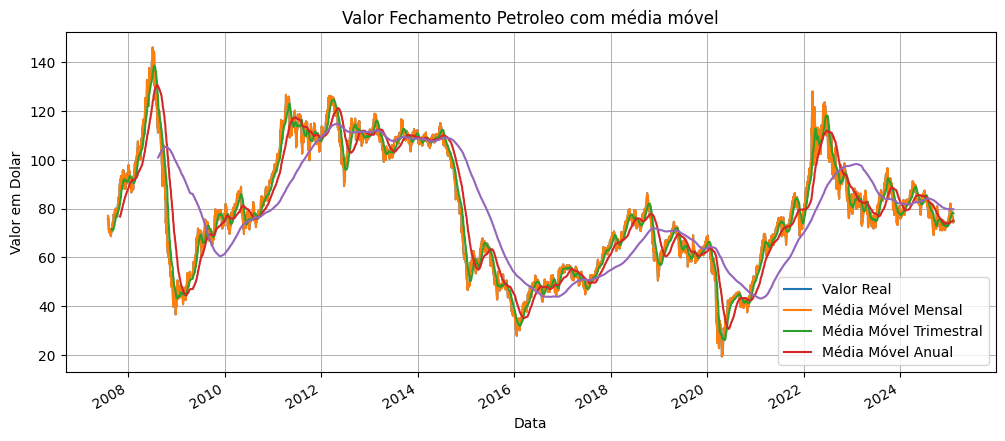

X_train: (3488, 5)
X_test: (872, 5)
MAE: 1.710936966292355
MSE: 2.2934050412141183
MAPE: 1.95 %


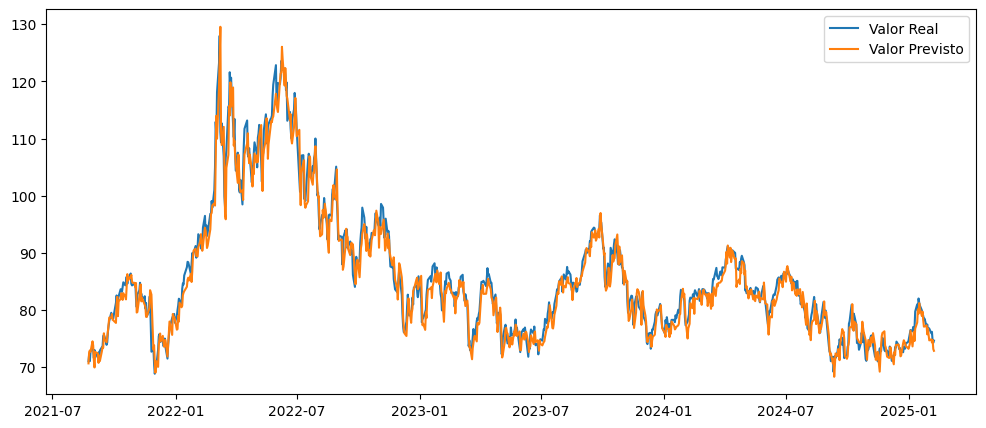

In [17]:
f = ForecastPetroleo()


fittado = f.fit()
fittado.plotarSerie(fittado.df['valor_fechamento'])
fittado.plotar_medias_moveis(fittado.df['valor_fechamento'])
X_train, X_test, y_train, y_test = fittado.prepare_data()
model = fittado.train_model(X_train, y_train)
y_pred = fittado.evaluate_model(model, X_test, y_test)
fittado.plot_predictions_with_test(y_test, y_pred)

